In [1]:
from components.HarvestWorld import HarvestWorld

from importlib import import_module, reload

import ipywidgets as widgets

import matplotlib.pyplot as plt
from IPython.display import clear_output

import numpy as np

harvest_world_module = import_module('components.HarvestWorld')
reload(harvest_world_module)

<module 'components.HarvestWorld' from '/home/raul/Escritorio/extra/misis/rl/rl_uniandes/dynamic_actions/components/HarvestWorld.py'>

In [2]:
ASCII_MAP = """
A        AA 
AA          
A          Q  
"""

# debug = [len(i) for i in ASCII_MAP.strip().split('\n')]
harvest_world = HarvestWorld(ASCII_MAP, 
                            regrowth_probs=[0.0, 0.005],
                            num_agents=1)
    

In [3]:
# Train the agent:
for _ in range(2):
    harvest_world.advance_timestep()

In [ ]:
def update_plot(freq):
    clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, figsize=(20, 15))
    harvest_world.plot_map(axes[0])
    harvest_world.agents[0].plot_knowledge(axes[1])
    harvest_world.advance_timestep()
    
freq_slider = widgets.FloatSlider(value=0, min=0, max=10, step=1, description='Frequency:')
out = widgets.interactive_output(update_plot, {'freq': freq_slider})
display(freq_slider, out)

FloatSlider(value=0.0, description='Frequency:', max=10.0, step=1.0)

Output()

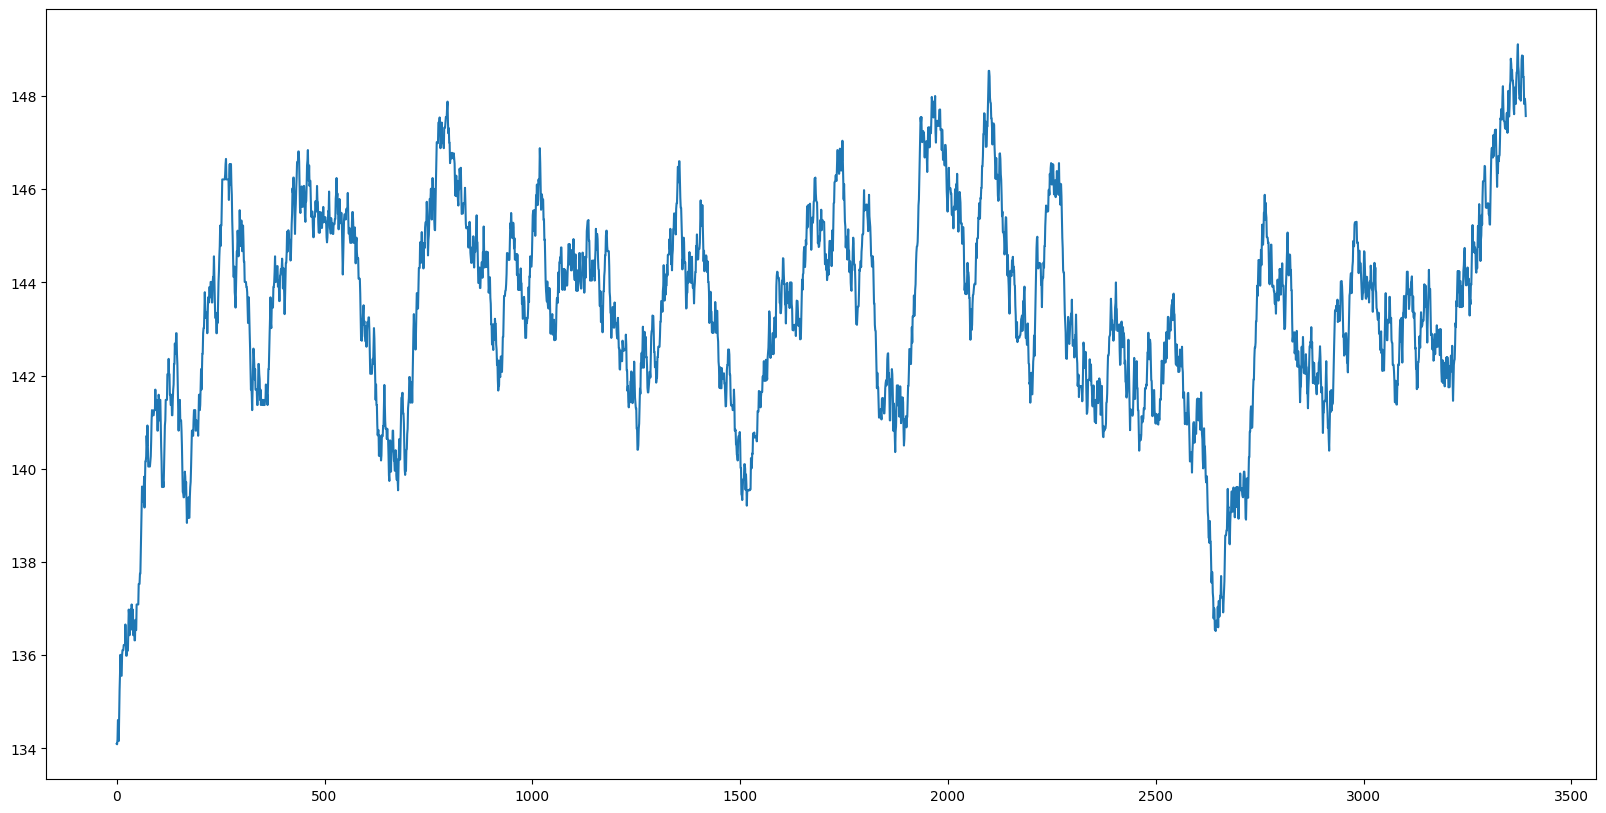

In [7]:
agent_data = harvest_world.agents[0]

def moving_average(a, n):

    test = np.cumsum(a, dtype=float)

    test[n:] = test[n:] - test[:-n]

    return test[n - 1:] / n

plt.figure(figsize=(20, 10))
plt.plot(moving_average(agent_data.duration, 100), )

In [ ]:
1-harvest_world.agents[0].timestep/500

0.946

In [ ]:
harvest_world.agents[0].q_knowledge[(1,0,'medio')]

{'right': 1.5925504917957984,
 'down': 1.6683124523860533,
 'up': 1.6269172220090526,
 'left': 1.523521666675284}

In [ ]:
harvest_world.agents[0].current_state

(0, 8, 'medio')